In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from models.mistral import Mistral

language_model = Mistral()

/home/nhb25/.conda/envs/dsl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:33<00:00, 11.09s/it]


In [4]:
prompt = "<s>[INST] Complete the last two sentences of the following story.[/INST] Title: A Hot Day\nStory: One summer day it was very hot and humid. No one in the town could keep cool. The sheriff sat in front of a fan all day.\nLast two sentences:"

print(language_model(prompt, num_samples=2, temperature=0.7))

{'generated_text': ['Suddenly, a gust of wind blew through the open windows, bringing with it a cool breeze. The sheriff sighed in relief, grateful for the unexpected relief from the heat. The townspeople rejoiced as well, coming out of their homes to enjoy the refreshing air. It was a welcome respite from the sweltering heat.', 'He sipped water constantly, but the heat was relentless. Finally, as the sun began to set, the temperature slowly started to drop and the townspeople breathed a sigh of relief, grateful for the end of the scorching day.'], 'logprobs': array([-35.661404, -25.038776], dtype=float32)}


In [5]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']

# Sentences are encoded by calling model.encode()
embedding = embedding_model.encode(sentence)

print(embedding.shape)

(1, 768)


## Datasets

In [79]:
import pandas as pd
from run_exp import preprocess_rocstories


df = pd.read_csv('datasets/ROCStories/dataset_2017.csv')

dataset = preprocess_rocstories(df, max_samples=5)
print(dataset[0])

{'prompt': '<s>[INST] Complete the last two sentences of the following story.[/INST] Title: Gambler\nStory: Katherine was born with the gift to gamble. She thought she was the best there was at gambling. She entered a local poker tournament.\nLast two sentences:', 'completion': 'The tournament lasted twenty-four hours. In the end, Katherine won and took home the prize of five grand.'}


In [80]:
dataset[0]

{'prompt': '<s>[INST] Complete the last two sentences of the following story.[/INST] Title: Gambler\nStory: Katherine was born with the gift to gamble. She thought she was the best there was at gambling. She entered a local poker tournament.\nLast two sentences:',
 'completion': 'The tournament lasted twenty-four hours. In the end, Katherine won and took home the prize of five grand.'}

## Diverse Sampling via Temperature

In [49]:
import numpy as np
from metrics import compute_metrics, ResultCollector
from visualize import plot
from run_exp import evaluate_varying_param

param_to_vary = {
    'name': 'temperature',
    'min': 0.2,
    'max': 1.0,
    'step': 0.2
}
k = 5
naive_res = evaluate_varying_param(dataset, naive_decoding, embedding_model, k, param_to_vary=param_to_vary, num_samples=1)

plot([naive_res], ['Naive Decoding'], 'cosine_similarity', 'log_probs')
plot([naive_res], ['Naive Decoding'], 'dpp_score', 'log_probs')

print(naive_res.get_summarized_results())

{'log_probs': -55.88775978088379, 'cosine_similarity': 0.8132140636444092, 'dpp_score': 0.005586114162668095, 'lp_distance': 0.5518536186218261}
{'log_probs': -101.69832992553711, 'cosine_similarity': 0.6854563903808594, 'dpp_score': 0.020946377535076423, 'lp_distance': 0.7621272182464599}
{'log_probs': -147.0195739746094, 'cosine_similarity': 0.6753072357177734, 'dpp_score': 0.027566435515646987, 'lp_distance': 0.7847495555877686}
{'log_probs': -218.67188720703126, 'cosine_similarity': 0.7023429489135742, 'dpp_score': 0.01805222584253565, 'lp_distance': 0.7492544078826905}
{'log_probs': -130.8193877220154, 'cosine_similarity': 0.7190801596641541, 'dpp_score': 0.018037788263981787, 'lp_distance': 0.7119962000846863, 'temperature': 0.5}


[0.81321406 0.68545639 0.67530724 0.70234295] [ 55.88775978 101.69832993 147.01957397 218.67188721]


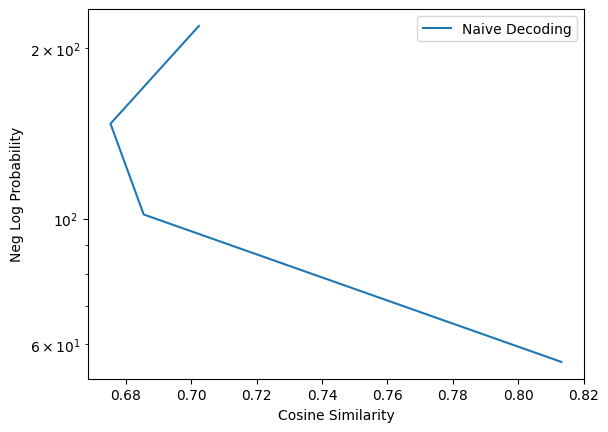

[0.00558611 0.02094638 0.02756644 0.01805223] [ 55.88775978 101.69832993 147.01957397 218.67188721]


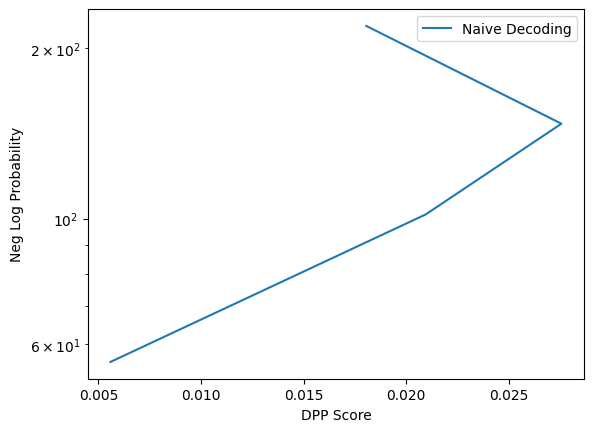

## Diverse Sampling via Oversampling and DPP selection

In [9]:

def diverse_decoding_via_over_sampling(prompt, language_model, embedding_model, k, n=100, temperature=0.7):
    sequences = pipeline(
        prompt,
        do_sample=True,
        temperature=temperature,
        num_return_sequences=n,
        max_length=1000,
    )

diverse_decoding_via_over_sampling("Hello! how are you doing?")

TypeError: diverse_decoding_via_over_sampling() missing 3 required positional arguments: 'language_model', 'embedding_model', and 'k'